In [41]:
# coding:utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, metrics
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder


# pandas
import pandas as pd
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 1000)

# LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 交差検証
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# AUC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
purchase_df = pd.read_csv('../input/purchase_record.csv')
user_df = pd.read_csv('../input/user_info.csv')
test_df = pd.read_csv('../input/purchase_record_test.csv')

In [3]:
purchase_df.shape

(1803574, 14)

In [4]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803574 entries, 0 to 1803573
Data columns (total 14 columns):
user_id        object
purchase_id    object
date           object
product_id     object
parts_1        object
parts_2        object
parts_3        object
parts_4        object
parts_5        object
parts_6        object
parts_7        object
parts_8        object
parts_9        object
purchase       int64
dtypes: int64(1), object(13)
memory usage: 192.6+ MB


In [5]:
purchase_df.head()

user_id     purchase_id        date product_id parts_1 parts_2 parts_3  \
0     uid_100  pid_0000000000  2017-09-27  product 2     NaN     NaN     NaN   
1     uid_100  pid_0000000001  2017-09-27  product 2     NaN     NaN     NaN   
2  uid_100002  pid_0000000002  2017-11-23  product 2     NaN     NaN     NaN   
3  uid_100002  pid_0000000003  2017-11-23  product 2     NaN     NaN     NaN   
4  uid_100003  pid_0000000004  2018-02-07  product 2     NaN     NaN     NaN   

  parts_4 parts_5 parts_6 parts_7 parts_8 parts_9  purchase  
0     NaN     NaN     NaN     NaN     NaN     NaN         0  
1     NaN     NaN     NaN     NaN     NaN     NaN         0  
2     NaN     NaN     NaN     NaN     NaN     NaN         1  
3     NaN     NaN     NaN     NaN     NaN     NaN         1  
4     NaN     NaN     NaN     NaN     NaN     NaN         1

In [6]:
purchase_df.fillna(0, inplace=True)

In [7]:
purchase_df.purchase.value_counts()

0    928044
1    875530
Name: purchase, dtype: int64

In [8]:
user_df.shape

(189114, 32)

In [9]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189114 entries, 0 to 189113
Data columns (total 32 columns):
user_id         189114 non-null object
date            189114 non-null object
attribute_1     189114 non-null object
attribute_2     189114 non-null object
attribute_3     189114 non-null object
attribute_4     189114 non-null bool
attribute_5     189114 non-null bool
attribute_6     189114 non-null bool
attribute_7     189114 non-null bool
attribute_8     189114 non-null bool
attribute_9     189114 non-null bool
attribute_10    189114 non-null bool
attribute_11    189114 non-null bool
attribute_12    189114 non-null bool
attribute_13    189114 non-null bool
attribute_14    189114 non-null bool
attribute_15    189114 non-null bool
attribute_16    189114 non-null bool
attribute_17    189114 non-null bool
attribute_18    189114 non-null bool
attribute_19    189114 non-null bool
attribute_20    189114 non-null bool
attribute_21    189114 non-null bool
attribute_22    189114 non-n

In [10]:
user_df.head()

user_id        date attribute_1 attribute_2 attribute_3  attribute_4  \
0     uid_100  2016-06-29        id 5        id 5        id 5         True   
1  uid_100002  2016-01-06       id 28        id 9        id 5        False   
2  uid_100003  2017-06-10        id 4        id 8        id 5         True   
3  uid_100004  2017-07-20       id 40       id 25        id 9         True   
4  uid_100006  2017-07-27       id 40       id 25        id 9        False   

   attribute_5  attribute_6  attribute_7  attribute_8  ...  attribute_21  \
0        False        False         True         True  ...          True   
1        False         True         True        False  ...         False   
2         True         True         True         True  ...          True   
3         True         True         True         True  ...          True   
4        False        False        False        False  ...         False   

   attribute_22  attribute_23  attribute_24  attribute_25  attribute_26  \
0         False          True          True         False         False   
1         False          True          True          True          True   
2         False         False          True          True          True   
3          True          True          True          True          True   
4         False         False          True         False         False   

   attribute_27  attribute_28  attribute_29  attribute_30  
0          True          True          True         False  
1          True          True          True         False  
2          True         False          True          True  
3          True          True          True          True  
4         False          True          True         False  

[5 rows x 32 columns]

In [11]:
test_df.head()

user_id     purchase_id        date product_id parts_1 parts_2 parts_3  \
0     uid_100  pid_0001803575  2018-08-26  product 4     NaN     NaN     NaN   
1     uid_100  pid_0001803576  2018-08-04  product 2     NaN     NaN     NaN   
2     uid_100  pid_0001803577  2018-08-26  product 2     NaN     NaN     NaN   
3     uid_100  pid_0001803578  2018-08-04  product 4     NaN     NaN     NaN   
4  uid_100003  pid_0001803579  2018-08-02  product 2     NaN     NaN     NaN   

  parts_4 parts_5 parts_6 parts_7 parts_8 parts_9  
0     NaN     NaN     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN     NaN     NaN

**学習データ・テストデータを結合**

In [12]:
# data_yに目的変数を代入
y_train = purchase_df['purchase']
# data_yの表示
print( y_train )

# data_Xに説明変数を代入
X_train = purchase_df.drop('purchase', axis=1)
# data_Xの表示
print( X_train )

0          0
1          0
2          1
3          1
4          1
          ..
1803569    1
1803570    1
1803571    1
1803572    1
1803573    1
Name: purchase, Length: 1803574, dtype: int64
            user_id     purchase_id        date product_id parts_1 parts_2  \
0           uid_100  pid_0000000000  2017-09-27  product 2       0       0   
1           uid_100  pid_0000000001  2017-09-27  product 2       0       0   
2        uid_100002  pid_0000000002  2017-11-23  product 2       0       0   
3        uid_100002  pid_0000000003  2017-11-23  product 2       0       0   
4        uid_100003  pid_0000000004  2018-02-07  product 2       0       0   
...             ...             ...         ...        ...     ...     ...   
1803569   uid_99994  pid_0001803569  2018-06-16  product 4       0       0   
1803570   uid_99994  pid_0001803570  2018-03-30  product 4       0       0   
1803571   uid_99994  pid_0001803571  2018-01-19  product 2       0       0   
1803572   uid_99994  pid_000180

In [13]:
all_df = pd.concat([X_train, test_df])

In [14]:
all_df = pd.merge(all_df, user_df, how='left', on='user_id')

In [15]:
all_df.head()

user_id     purchase_id      date_x product_id parts_1 parts_2 parts_3  \
0     uid_100  pid_0000000000  2017-09-27  product 2       0       0       0   
1     uid_100  pid_0000000001  2017-09-27  product 2       0       0       0   
2  uid_100002  pid_0000000002  2017-11-23  product 2       0       0       0   
3  uid_100002  pid_0000000003  2017-11-23  product 2       0       0       0   
4  uid_100003  pid_0000000004  2018-02-07  product 2       0       0       0   

  parts_4 parts_5 parts_6  ... attribute_21 attribute_22 attribute_23  \
0       0       0       0  ...         True        False         True   
1       0       0       0  ...         True        False         True   
2       0       0       0  ...        False        False         True   
3       0       0       0  ...        False        False         True   
4       0       0       0  ...         True        False        False   

  attribute_24 attribute_25 attribute_26 attribute_27  attribute_28  \
0         True        False        False         True          True   
1         True        False        False         True          True   
2         True         True         True         True          True   
3         True         True         True         True          True   
4         True         True         True         True         False   

   attribute_29  attribute_30  
0          True         False  
1          True         False  
2          True         False  
3          True         False  
4          True          True  

[5 rows x 44 columns]

In [16]:
all_df.shape
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018615 entries, 0 to 2018614
Data columns (total 44 columns):
user_id         object
purchase_id     object
date_x          object
product_id      object
parts_1         object
parts_2         object
parts_3         object
parts_4         object
parts_5         object
parts_6         object
parts_7         object
parts_8         object
parts_9         object
date_y          object
attribute_1     object
attribute_2     object
attribute_3     object
attribute_4     bool
attribute_5     bool
attribute_6     bool
attribute_7     bool
attribute_8     bool
attribute_9     bool
attribute_10    bool
attribute_11    bool
attribute_12    bool
attribute_13    bool
attribute_14    bool
attribute_15    bool
attribute_16    bool
attribute_17    bool
attribute_18    bool
attribute_19    bool
attribute_20    bool
attribute_21    bool
attribute_22    bool
attribute_23    bool
attribute_24    bool
attribute_25    bool
attribute_26    bool
attribute_27 

**特徴量生成**
* product_idをfrequency_encoding 
* user_idをfrequency_encoding
* 顧客情報登録日から購入検討日までの日にち
* 購入日or顧客情報登録日は2015/1/1から何日経っているか
* 商品毎の悩まれる時間の統計量(PC毎の検討時間の長さ)
* ユーザー毎の悩まれる時間の統計量

In [17]:
# product_idをfrequency_encodingする
grouped_product_id = all_df.groupby("product_id").size().reset_index(name='product_id_counts') # 出現回数を計算
# もとのデータセットにカテゴリーをproduct_idとして結合
all_df = all_df.merge(grouped_product_id, how = "left", on = "product_id")
all_df["product_id_frequency"] = all_df["product_id_counts"] / all_df["product_id_counts"].count()
#product_idを削除する
# train_df = train_df.drop('product_id_counts', axis=1)

# ユーザーの出現回数(検討回数)列をfrequency_encodingで追加
grouped_user_id = all_df.groupby("user_id").size().reset_index(name='user_id_counts') # 出現回数を計算
# もとのデータセットにカテゴリーをuser_idとして結合
all_df = all_df.merge(grouped_user_id, how = "left", on = "user_id")
all_df["user_id_frequency"] = all_df["user_id_counts"] / all_df["user_id_counts"].count()
# train_df = train_df.drop('product_id_counts', axis=1)

# データ開始から何日経っているかを表す列を追加date_x
all_df['date_x_days'] = np.nan # 欠損値で埋める
all_df['date_x_days'] = all_df.index.values # インデックス値を使用
all_df['date_x_days'] = pd.to_datetime(all_df['date_x']) # 日付データにリフォーマット
all_df['date_x_days'] = all_df['date_x_days'] - dt(2015,1,1)
all_df['date_x_days'] = all_df['date_x_days'].dt.days
# データ開始から何日経っているかを表す列を追加date_y
all_df['date_y_days'] = np.nan # 欠損値で埋める
all_df['date_y_days'] = all_df.index.values # インデックス値を使用
all_df['date_y_days'] = pd.to_datetime(all_df['date_y']) # 日付データにリフォーマット
all_df['date_y_days'] = all_df['date_y_days'] - dt(2015,1,1)
all_df['date_y_days'] = all_df['date_y_days'].dt.days
# 日付列削除
all_df = all_df.drop('date_x', axis=1)
all_df = all_df.drop('date_y', axis=1)

# 顧客属性登録日から購入検討日までの検討時間列を追加
all_df['days_y_minus_x'] = np.nan # 欠損値で埋める
all_df['days_y_minus_x'] = all_df.index.values # インデックス値を使用
all_df['days_y_minus_x'] = all_df['date_x_days'] - all_df['date_y_days']

# 商品毎の悩まれる時間の統計量(PC毎の検討時間の長さ)
# grouped_product_id = all_df.groupby("product_id").size().reset_index(name='product_id_counts') # 出現回数を計算
# all_df.groupby("product_id").size().reset_index(name='product_id_counts')
grouped_product_id_time = all_df.groupby("product_id").mean().product_id_counts.reset_index(name='product_id_time_mean')
# もとのデータセットにカテゴリーをproduct_idとして結合
all_df = all_df.merge(grouped_product_id_time, how = "left", on = "product_id")

# ユーザー毎の悩まれる時間の統計量
grouped_user_id_time = all_df.groupby("user_id").mean().days_y_minus_x.reset_index(name='user_id_time_mean')
# もとのデータセットにカテゴリーをproduct_idとして結合
all_df = all_df.merge(grouped_user_id_time, how = "left", on = "user_id")

# user_idを削除する
all_df = all_df.drop('user_id', axis=1)

In [18]:
all_df.head()

purchase_id product_id parts_1 parts_2 parts_3 parts_4 parts_5 parts_6  \
0  pid_0000000000  product 2       0       0       0       0       0       0   
1  pid_0000000001  product 2       0       0       0       0       0       0   
2  pid_0000000002  product 2       0       0       0       0       0       0   
3  pid_0000000003  product 2       0       0       0       0       0       0   
4  pid_0000000004  product 2       0       0       0       0       0       0   

  parts_7 parts_8  ... attribute_30 product_id_counts product_id_frequency  \
0       0       0  ...        False            904561              0.44811   
1       0       0  ...        False            904561              0.44811   
2       0       0  ...        False            904561              0.44811   
3       0       0  ...        False            904561              0.44811   
4       0       0  ...         True            904561              0.44811   

  user_id_counts  user_id_frequency  date_x_days  date_y_days  days_y_minus_x  \
0              6       2.972335e-06         1000          545             455   
1              6       2.972335e-06         1000          545             455   
2              2       9.907783e-07         1057          370             687   
3              2       9.907783e-07         1057          370             687   
4             34       1.684323e-05         1133          891             242   

   product_id_time_mean  user_id_time_mean  
0              904561.0         669.666667  
1              904561.0         669.666667  
2              904561.0         687.000000  
3              904561.0         687.000000  
4              904561.0         226.411765  

[5 rows x 50 columns]

In [19]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018615 entries, 0 to 2018614
Data columns (total 50 columns):
purchase_id             object
product_id              object
parts_1                 object
parts_2                 object
parts_3                 object
parts_4                 object
parts_5                 object
parts_6                 object
parts_7                 object
parts_8                 object
parts_9                 object
attribute_1             object
attribute_2             object
attribute_3             object
attribute_4             bool
attribute_5             bool
attribute_6             bool
attribute_7             bool
attribute_8             bool
attribute_9             bool
attribute_10            bool
attribute_11            bool
attribute_12            bool
attribute_13            bool
attribute_14            bool
attribute_15            bool
attribute_16            bool
attribute_17            bool
attribute_18            bool
attribute_19      

In [20]:
all_df.shape

(2018615, 50)

In [21]:
all_df.isnull().sum().sum()

1746315

In [22]:
%%time
# train = pd.get_dummies(train_df, drop_first=True)
all = pd.get_dummies(all_df, columns=['product_id', 'attribute_1', 'attribute_2', 'attribute_3', 'parts_1', 'parts_2', 'parts_3', 'parts_4', 'parts_5', 'parts_6', 'parts_7', 'parts_8', 'parts_9'], drop_first=True)
all = all * 1
all = all.set_index('purchase_id')
# train = pd.get_dummies(train_df, columns!=['purchase_id', 'purchase'], drop_first=True)



CPU times: user 3.76 s, sys: 1.74 s, total: 5.51 s
Wall time: 5.64 s


In [23]:
all.head()

attribute_4  attribute_5  attribute_6  attribute_7  \
purchase_id                                                          
pid_0000000000            1            0            0            1   
pid_0000000001            1            0            0            1   
pid_0000000002            0            0            1            1   
pid_0000000003            0            0            1            1   
pid_0000000004            1            1            1            1   

                attribute_8  attribute_9  attribute_10  attribute_11  \
purchase_id                                                            
pid_0000000000            1            0             1             0   
pid_0000000001            1            0             1             0   
pid_0000000002            0            0             0             1   
pid_0000000003            0            0             0             1   
pid_0000000004            1            1             0             1   

                attribute_12  attribute_13  ...  parts_9_id 18  parts_9_id 19  \
purchase_id                                 ...                                 
pid_0000000000             0             0  ...              0              0   
pid_0000000001             0             0  ...              0              0   
pid_0000000002             0             0  ...              0              0   
pid_0000000003             0             0  ...              0              0   
pid_0000000004             0             1  ...              0              0   

                parts_9_id 2  parts_9_id 3  parts_9_id 4  parts_9_id 5  \
purchase_id                                                              
pid_0000000000             0             0             0             0   
pid_0000000001             0             0             0             0   
pid_0000000002             0             0             0             0   
pid_0000000003             0             0             0             0   
pid_0000000004             0             0             0             0   

                parts_9_id 6  parts_9_id 7  parts_9_id 8  parts_9_id 9  
purchase_id                                                             
pid_0000000000             0             0             0             0  
pid_0000000001             0             0             0             0  
pid_0000000002             0             0             0             0  
pid_0000000003             0             0             0             0  
pid_0000000004             0             0             0             0  

[5 rows x 274 columns]

In [24]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2018615 entries, pid_0000000000 to pid_0002018615
Columns: 274 entries, attribute_4 to parts_9_id 9
dtypes: float64(4), int64(32), uint8(238)
memory usage: 1.0+ GB


**学習データ・テストデータに分割**

In [25]:
# X_trainに説明変数を代入
X_train = all[:1803574]

# y_trainに目的変数を代入
# y_train = y_train

# テストデータ作成
test = all[1803574:]

In [26]:
# data_Xの表示
X_train.tail()

attribute_4  attribute_5  attribute_6  attribute_7  \
purchase_id                                                          
pid_0001803569            1            1            1            1   
pid_0001803570            1            1            1            1   
pid_0001803571            1            1            1            1   
pid_0001803572            1            1            1            1   
pid_0001803573            1            1            1            1   

                attribute_8  attribute_9  attribute_10  attribute_11  \
purchase_id                                                            
pid_0001803569            1            1             1             1   
pid_0001803570            1            1             1             1   
pid_0001803571            1            1             1             1   
pid_0001803572            1            1             1             1   
pid_0001803573            1            1             1             1   

                attribute_12  attribute_13  ...  parts_9_id 18  parts_9_id 19  \
purchase_id                                 ...                                 
pid_0001803569             1             1  ...              0              0   
pid_0001803570             1             1  ...              0              0   
pid_0001803571             1             1  ...              0              0   
pid_0001803572             1             1  ...              0              0   
pid_0001803573             1             1  ...              0              0   

                parts_9_id 2  parts_9_id 3  parts_9_id 4  parts_9_id 5  \
purchase_id                                                              
pid_0001803569             0             0             0             0   
pid_0001803570             0             0             0             0   
pid_0001803571             0             0             0             0   
pid_0001803572             0             0             0             0   
pid_0001803573             0             0             0             0   

                parts_9_id 6  parts_9_id 7  parts_9_id 8  parts_9_id 9  
purchase_id                                                             
pid_0001803569             0             0             0             0  
pid_0001803570             0             0             0             0  
pid_0001803571             0             0             0             0  
pid_0001803572             0             0             0             0  
pid_0001803573             0             0             0             0  

[5 rows x 274 columns]

In [27]:
# data_yの表示
test.head()

attribute_4  attribute_5  attribute_6  attribute_7  \
purchase_id                                                          
pid_0001803575            1            0            0            1   
pid_0001803576            1            0            0            1   
pid_0001803577            1            0            0            1   
pid_0001803578            1            0            0            1   
pid_0001803579            1            1            1            1   

                attribute_8  attribute_9  attribute_10  attribute_11  \
purchase_id                                                            
pid_0001803575            1            0             1             0   
pid_0001803576            1            0             1             0   
pid_0001803577            1            0             1             0   
pid_0001803578            1            0             1             0   
pid_0001803579            1            1             0             1   

                attribute_12  attribute_13  ...  parts_9_id 18  parts_9_id 19  \
purchase_id                                 ...                                 
pid_0001803575             0             0  ...              0              0   
pid_0001803576             0             0  ...              0              0   
pid_0001803577             0             0  ...              0              0   
pid_0001803578             0             0  ...              0              0   
pid_0001803579             0             1  ...              0              0   

                parts_9_id 2  parts_9_id 3  parts_9_id 4  parts_9_id 5  \
purchase_id                                                              
pid_0001803575             0             0             0             0   
pid_0001803576             0             0             0             0   
pid_0001803577             0             0             0             0   
pid_0001803578             0             0             0             0   
pid_0001803579             0             0             0             0   

                parts_9_id 6  parts_9_id 7  parts_9_id 8  parts_9_id 9  
purchase_id                                                             
pid_0001803575             0             0             0             0  
pid_0001803576             0             0             0             0  
pid_0001803577             0             0             0             0  
pid_0001803578             0             0             0             0  
pid_0001803579             0             0             0             0  

[5 rows x 274 columns]

fold1 start
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.544169	valid_1's binary_logloss: 0.545972
oof: [1 0 1 ... 1 1 1]
AUC: [0.7263141355918628]
fold1 end

fold2 start
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.543339	valid_1's binary_logloss: 0.543709
oof: [0 1 1 ... 1 1 1]
AUC: [0.7263141355918628, 0.7283683287768281]
fold2 end

fold3 start
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.541791	valid_1's binary_logloss: 0.542021
oof: [1 1 1 ... 1 1 1]
AUC: [0.7263141355918628, 0.7283683287768281, 0.7316612584502357]
fold3 end

fold4 start
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.543992

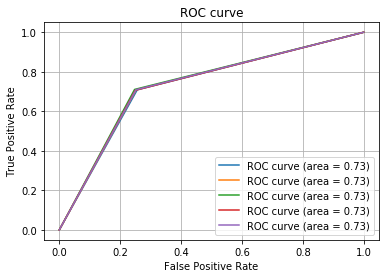

In [28]:
%%time
# 5分割交差検証を指定し、インスタンス化
n_splits = 5
kf = KFold(n_splits, shuffle=True)

# スコアとモデルを格納するリスト
score_list = []
models = []

for fold_, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print(f'fold{fold_ + 1} start')
    train_x = X_train.iloc[train_index]
    valid_x = X_train.iloc[valid_index]
    train_y = y_train[train_index]
    valid_y = y_train[valid_index]
    # lab.Datasetを使って,trainとvalidを作っておく
    lgb_train= lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)

    # パラメータを定義
    lgbm_params = {'objective': 'binary'}                                                                                               
          
    # 学習
    gbm = lgb.train(params = lgbm_params,
                    train_set = lgb_train, 
                    valid_sets = [lgb_train, lgb_valid],
                    early_stopping_rounds = 20,
                    verbose_eval = -1 # 学習の状況を表示しない
                   )

    oof = (gbm.predict(valid_x) > 0.5).astype(int)
    # oof = gbm.predict(valid_x)
    print('oof:', oof)
    # AUC算出
    # auc = metrics.auc(valid_y, oof)
    auc = roc_auc_score(valid_y, oof)
    score_list.append(auc) # スコアリストに保存
    # score_list.append(np.sqrt(mean_squared_error(valid_y, oof))) #RMSEを出す
    # score_list.append(round(accuracy_score(valid_y, oof)*100,2)) # 正解率Accuracyを出す。(検証用y, 予測結果)
    print('AUC:', score_list)
    models.append(gbm) # 学習が終わったモデルをリストに入れておく
    print(f'fold{fold_ + 1} end\n' )
    
    # FPR, TPR(, しきい値) を算出
    fpr, tpr, thresholds = metrics.roc_curve(valid_y, oof)
    
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

In [29]:
print(score_list, '平均score', round(np.mean(score_list), 2))

[0.7263141355918628, 0.7283683287768281, 0.7316612584502357, 0.7282804201752135, 0.7286368468935327] 平均score 0.73


In [30]:
# 比較
# p = pd.DataFrame({"actual":valid_y,"pred":oof})
# p.plot(figsize=(15,4))
# print("AUC",round(np.mean(score_list), 2))

In [31]:
# テストデータの予測を格納する。テストデータ列数*分割数列のnumpy行列を作成
test_pred = np.zeros((len(test), n_splits))

# 分割検証結果の平均を取る
for fold_, gbm in enumerate(models):
    pred_ = gbm.predict(test) # testを予測
    test_pred[:, fold_] = pred_

result = pd.DataFrame({
    'purchase_id': test.index.values,
    'probability': np.mean(test_pred, axis=1)
    # 'probability': (np.mean(test_pred, axis=1) > 0.5).astype(int)
})

# pred = (np.mean(test_pred, axis=1) > 0.5).astype(int)
# result['probability'] = pred
result.to_csv('../output/submit.csv',header=False,index=False)

In [32]:
test_pred

array([[0.72354575, 0.70483698, 0.71726275, 0.71557017, 0.68218851],
       [0.71840262, 0.70483698, 0.71784156, 0.71557017, 0.685163  ],
       [0.71840262, 0.70483698, 0.71784156, 0.71557017, 0.685163  ],
       ...,
       [0.76182467, 0.76916224, 0.7759743 , 0.75920638, 0.76479158],
       [0.76182467, 0.76916224, 0.7759743 , 0.75920638, 0.76479158],
       [0.76182467, 0.76916224, 0.7759743 , 0.75920638, 0.76479158]])

In [33]:
np.set_printoptions(threshold=np.inf)
# print(pred_)

[0.68218851 0.685163   0.685163   0.68218851 0.84083474 0.84083474
 0.84083474 0.84083474 0.84083474 0.29676987 0.70574675 0.74738834
 0.74738834 0.74738834 0.74738834 0.74738834 0.7422916  0.74738834
 0.72981078 0.62034467 0.31923854 0.31923854 0.79444062 0.79444062
 0.79444062 0.7835832  0.80403031 0.80403031 0.17674465 0.27565886
 0.78210563 0.78210563 0.78210563 0.78210563 0.33032671 0.34401298
 0.35035191 0.307113   0.307113   0.30876669 0.32733827 0.31848049
 0.32911246 0.25189053 0.2687473  0.17118169 0.16287681 0.16713753
 0.17639266 0.16713753 0.16713753 0.16713753 0.17639266 0.17639266
 0.16713753 0.17639266 0.16713753 0.26459003 0.29963944 0.87657049
 0.87657049 0.72845365 0.76440038 0.76440038 0.70070325 0.70881887
 0.89325952 0.89325952 0.20266757 0.1908581  0.1908581  0.1908581
 0.20266757 0.20266757 0.20266757 0.20266757 0.20266757 0.20266757
 0.20266757 0.20266757 0.20266757 0.20266757 0.1908581  0.87681257
 0.87681257 0.87090655 0.87090655 0.79449387 0.87090655 0.87090

In [34]:
import datetime
dt_now = datetime.datetime.now()
print(dt_now)
print("予測完了")

2019-11-27 22:43:02.135435
予測完了


**販売確率の高い上位15の商品ラインナップ** 
全データに対して予測を行い、確率が高いものからソートする

In [42]:
all.head()

attribute_4  attribute_5  attribute_6  attribute_7  \
purchase_id                                                          
pid_0000000000            1            0            0            1   
pid_0000000001            1            0            0            1   
pid_0000000002            0            0            1            1   
pid_0000000003            0            0            1            1   
pid_0000000004            1            1            1            1   
pid_0000000005            1            1            1            1   
pid_0000000006            1            1            1            1   
pid_0000000007            1            1            1            1   
pid_0000000008            1            1            1            1   
pid_0000000009            1            1            1            1   
pid_0000000010            1            1            1            1   
pid_0000000011            1            1            1            1   
pid_0000000012            1            1            1            1   
pid_0000000013            1            1            1            1   
pid_0000000014            1            1            1            1   
pid_0000000015            1            1            1            1   
pid_0000000016            1            1            1            1   
pid_0000000017            1            1            1            1   
pid_0000000018            1            1            1            1   
pid_0000000019            1            1            1            1   
pid_0000000020            1            1            1            1   
pid_0000000021            1            1            1            1   
pid_0000000022            1            1            1            1   
pid_0000000023            1            1            1            1   
pid_0000000024            1            1            1            1   
pid_0000000025            1            1            1            1   
pid_0000000026            1            1            1            1   
pid_0000000027            1            1            1            1   
pid_0000000028            1            1            1            1   
pid_0000000029            1            1            1            1   
pid_0000000030            1            1            1            1   
pid_0000000031            1            1            1            1   
pid_0000000032            1            1            1            1   
pid_0000000033            0            0            0            0   
pid_0000000034            0            0            0            0   
pid_0000000035            0            0            0            0   
pid_0000000036            1            0            1            1   
pid_0000000037            1            0            1            1   
pid_0000000038            1            0            1            1   
pid_0000000039            1            0            1            1   
pid_0000000040            1            0            1            1   
pid_0000000041            0            0            0            0   
pid_0000000042            0            0            0            0   
pid_0000000043            0            0            0            0   
pid_0000000044            0            0            0            0   
pid_0000000045            0            0            0            0   
pid_0000000046            0            0            0            0   
pid_0000000047            0            0            0            0   
pid_0000000048            0            0            0            0   
pid_0000000049            0            0            0            0   
pid_0000000050            0            0            0            0   
pid_0000000051            0            0            0            0   
pid_0000000052            0            0            0            0   
pid_0000000053            0            0            0            0   
pid_0000000054            0            0            0            0   
pid_0000000055            

In [46]:
all_pred = np.zeros((len(all), n_splits))

In [63]:
# 分割検証結果の平均を取る
for fold_, gbm in enumerate(models):
    pred_ = gbm.predict(all) # allを予測
    all_pred[:, fold_] = pred_
    
result = pd.DataFrame({
    'purchase_id': all.index.values,
    'probability': np.mean(all_pred, axis=1)
})

result.to_csv('../output/rankingScore.csv',header=False,index=False)

In [66]:
allPredict_df = pd.read_csv('../output/rankingScore.csv', header=None)
allPredict_df = pd.DataFrame({
    'purchase_id': allPredict_df.iloc[:, 0],
    'predict': allPredict_df.iloc[:,1]
})
allPredictRanking_df = pd.merge(all_df, allPredict_df, how='left', on='purchase_id')
#allPredictRanking_df.head()

purchase_id product_id parts_1 parts_2 parts_3 parts_4 parts_5  \
0    pid_0000000000  product 2       0       0       0       0       0   
1    pid_0000000001  product 2       0       0       0       0       0   
2    pid_0000000002  product 2       0       0       0       0       0   
3    pid_0000000003  product 2       0       0       0       0       0   
4    pid_0000000004  product 2       0       0       0       0       0   
5    pid_0000000005  product 2       0       0       0       0       0   
6    pid_0000000006  product 4       0       0       0       0       0   
7    pid_0000000007  product 4       0       0       0       0       0   
8    pid_0000000008  product 2       0       0       0       0       0   
9    pid_0000000009  product 4       0       0       0       0       0   
10   pid_0000000010  product 4       0       0       0       0       0   
11   pid_0000000011  product 2       0       0       0       0       0   
12   pid_0000000012  product 2       0       0       0       0       0   
13   pid_0000000013  product 2       0       0       0       0       0   
14   pid_0000000014  product 2       0       0       0       0       0   
15   pid_0000000015  product 4       0       0       0       0       0   
16   pid_0000000016  product 2       0       0       0       0       0   
17   pid_0000000017  product 2       0       0       0       0       0   
18   pid_0000000018  product 2       0       0       0       0       0   
19   pid_0000000019  product 2       0       0       0       0       0   
20   pid_0000000020  product 4       0       0       0       0       0   
21   pid_0000000021  product 2       0       0       0       0       0   
22   pid_0000000022  product 2       0       0       0       0       0   
23   pid_0000000023  product 2       0       0       0       0       0   
24   pid_0000000024  product 2       0       0       0       0       0   
25   pid_0000000025  product 2       0       0       0       0       0   
26   pid_0000000026  product 2       0       0       0       0       0   
27   pid_0000000027  product 2       0       0       0       0       0   
28   pid_0000000028  product 2       0       0       0       0       0   
29   pid_0000000029  product 4       0       0       0       0       0   
30   pid_0000000030  product 4       0       0       0       0       0   
31   pid_0000000031  product 4       0       0       0       0       0   
32   pid_0000000032  product 4       0       0       0       0       0   
33   pid_0000000033  product 4       0       0       0       0       0   
34   pid_0000000034  product 3       0       0       0       0       0   
35   pid_0000000035  product 4       0       0       0       0       0   
36   pid_0000000036  product 5       0       0       0       0       0   
37   pid_0000000037  product 5       0       0       0       0       0   
38   pid_0000000038  product 5       0       0       0       0       0   
39   pid_0000000039  product 5       0       0       0       0       0   
40   pid_0000000040  product 5       0       0       0       0       0   
41   pid_0000000041  product 3       0       0       0       0       0   
42   pid_0000000042  product 3       0       0       0       0       0   
43   pid_0000000043  product 1    id 3    id 5    id 1    id 1    id 6   
44   pid_0000000044  product 5       0       0       0       0       0   
45   pid_0000000045  product 5       0       0       0       0       0   
46   pid_0000000046  product 5       0       0       0       0       0   
47   pid_0000000047  product 5       0       0       0       0       0   
48   pid_0000000048  product 5       0       0       0       0       0   
49   pid_0000000049  product 5       0       0       0       0       0   
50   pid_0000000050  product 2       0       0       0       0       0   
51   pid_0000000051  product 5       0       0       0       0       0   
52   pid_0000000052  product 2       0       0       0       0       0   
53   pid_000

In [67]:
allPredictRanking_df = allPredictRanking_df.sort_values('predict', ascending=False)

purchase_id product_id parts_1 parts_2 parts_3 parts_4 parts_5  \
1626776  pid_0001626776  product 3       0       0       0       0       0   
1621704  pid_0001621704  product 3       0       0       0       0       0   
1621697  pid_0001621697  product 3       0       0       0       0       0   
1621698  pid_0001621698  product 3       0       0       0       0       0   
1621699  pid_0001621699  product 3       0       0       0       0       0   
1621701  pid_0001621701  product 3       0       0       0       0       0   
1621702  pid_0001621702  product 3       0       0       0       0       0   
1621703  pid_0001621703  product 3       0       0       0       0       0   
1621705  pid_0001621705  product 3       0       0       0       0       0   
1621695  pid_0001621695  product 3       0       0       0       0       0   
1621706  pid_0001621706  product 3       0       0       0       0       0   
1621707  pid_0001621707  product 3       0       0       0       0       0   
1621708  pid_0001621708  product 3       0       0       0       0       0   
1621709  pid_0001621709  product 3       0       0       0       0       0   
1621710  pid_0001621710  product 3       0       0       0       0       0   
1621711  pid_0001621711  product 3       0       0       0       0       0   
1621696  pid_0001621696  product 3       0       0       0       0       0   
1621694  pid_0001621694  product 3       0       0       0       0       0   
1621713  pid_0001621713  product 3       0       0       0       0       0   
1621685  pid_0001621685  product 3       0       0       0       0       0   
1621680  pid_0001621680  product 3       0       0       0       0       0   
1621681  pid_0001621681  product 3       0       0       0       0       0   
1624452  pid_0001624452  product 3       0       0       0       0       0   
1621682  pid_0001621682  product 3       0       0       0       0       0   
1621683  pid_0001621683  product 3       0       0       0       0       0   
1621684  pid_0001621684  product 3       0       0       0       0       0   
1621686  pid_0001621686  product 3       0       0       0       0       0   
1621693  pid_0001621693  product 3       0       0       0       0       0   
1621687  pid_0001621687  product 3       0       0       0       0       0   
1621688  pid_0001621688  product 3       0       0       0       0       0   
1621689  pid_0001621689  product 3       0       0       0       0       0   
1621690  pid_0001621690  product 3       0       0       0       0       0   
1621691  pid_0001621691  product 3       0       0       0       0       0   
1621692  pid_0001621692  product 3       0       0       0       0       0   
1621712  pid_0001621712  product 3       0       0       0       0       0   
1621714  pid_0001621714  product 3       0       0       0       0       0   
1621679  pid_0001621679  product 3       0       0       0       0       0   
1621740  pid_0001621740  product 3       0       0       0       0       0   
1621734  pid_0001621734  product 3       0       0       0       0       0   
1621735  pid_0001621735  product 3       0       0       0       0       0   
1621736  pid_0001621736  product 3       0       0       0       0       0   
1621737  pid_0001621737  product 3       0       0       0       0       0   
1621738  pid_0001621738  product 3       0       0       0       0       0   
1621739  pid_0001621739  product 3       0       0       0       0       0   
1621741  pid_0001621741  product 3       0       0       0       0       0   
1621732  pid_0001621732  product 3       0       0       0       0       0   
1621742  pid_0001621742  product 3       0       0       0       0       0   
1621743  pid_0001621743  product 3       0       0       0       0       0   
1621744  pid_0001621744  product 3       0       0       0       0       0   
1621745  pid_0001621745  product 3       0       0       0       0       0   
1621746  pid_0001621746  product 3

In [90]:
allPredictRankingGroup_df = allPredictRanking_df[~allPredictRanking_df.duplicated(subset=["predict"])]
allPredictRankingGroup_df
allPredictRankingGroup_df.to_csv('../output/rankingScoreSort.csv')

In [184]:
allPredictRankingGroup_df = allPredictRankingGroup_df.fillna('0')
allPredictRankingGroupProduct_df = allPredictRankingGroup_df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,50]]
allPredictRankingGroupProduct_df = allPredictRankingGroupProduct_df.drop('purchase_id', axis=1).reset_index(drop=True)
# allPredictRankingGroupProduct_df.head()

product_id parts_1 parts_2 parts_3 parts_4 parts_5 parts_6 parts_7  \
564083  product 1    id 7    id 5    id 6    id 3    id 6    id 2    id 3   
564084  product 1   id 11    id 7    id 7    id 4    id 6    id 3    id 5   
564085  product 2       0       0       0       0       0       0       0   
564086  product 2       0       0       0       0       0       0       0   
564087  product 2       0       0       0       0       0       0       0   
564088  product 2       0       0       0       0       0       0       0   
564089  product 1    id 1    id 3    id 1    id 1    id 1    id 1    id 1   
564090  product 2       0       0       0       0       0       0       0   
564091  product 2       0       0       0       0       0       0       0   
564092  product 2       0       0       0       0       0       0       0   
564093  product 2       0       0       0       0       0       0       0   
564094  product 2       0       0       0       0       0       0       0   
564095  product 2       0       0       0       0       0       0       0   
564096  product 2       0       0       0       0       0       0       0   
564097  product 4       0       0       0       0       0       0       0   
564098  product 4       0       0       0       0       0       0       0   
564099  product 5       0       0       0       0       0       0       0   
564100  product 2       0       0       0       0       0       0       0   
564101  product 2       0       0       0       0       0       0       0   
564102  product 2       0       0       0       0       0       0       0   
564103  product 4       0       0       0       0       0       0       0   
564104  product 2       0       0       0       0       0       0       0   
564105  product 4       0       0       0       0       0       0       0   
564106  product 4       0       0       0       0       0       0       0   
564107  product 2       0       0       0       0       0       0       0   
564108  product 4       0       0       0       0       0       0       0   
564109  product 2       0       0       0       0       0       0       0   
564110  product 3       0       0       0       0       0       0       0   
564111  product 3       0       0       0       0       0       0       0   
564112  product 3       0       0       0       0       0       0       0   
564113  product 4       0       0       0       0       0       0       0   
564114  product 2       0       0       0       0       0       0       0   
564115  product 2       0       0       0       0       0       0       0   
564116  product 2       0       0       0       0       0       0       0   
564117  product 2       0       0       0       0       0       0       0   
564118  product 4       0       0       0       0       0       0       0   
564119  product 2       0       0       0       0       0       0       0   
564120  product 2       0       0       0       0       0       0       0   
564121  product 1   id 41    id 9    id 5    id 6    id 6    id 1    id 1   
564122  product 4       0       0       0       0       0       0       0   
564123  product 2       0       0       0       0       0       0       0   
564124  product 2       0       0       0       0       0       0       0   
564125  product 2       0       0       0       0       0       0       0   
564126  product 5       0       0       0       0       0       0       0   
564127  product 3       0       0       0       0       0       0       0   
564128  product 2       0       0       0       0       0       0       0   
564129  product 2       0       0       0       0       0       0       0   
564130  product 4       0       0       0       0       0       0       0   
564131  product 4       0       0       0       0       0       0       0   
564132  product 2       0       0       0       0       0       0       0   
564133  product 2       0       0       0       0       0       0       0   
564

In [185]:
allPredictRankingGroupProductGroup_df = allPredictRankingGroupProduct_df.groupby(['product_id', 'parts_1', 'parts_2', 'parts_3', 'parts_4', 'parts_5', 'parts_6', 'parts_7', 'parts_8', 'parts_9']).mean()
allPredictRankingGroupProductGroup_df

predict
product_id parts_1 parts_2 parts_3 parts_4 parts_5 parts_6 parts_7 parts_8 parts_9          
product 1  id 1    id 1    id 1    id 1    id 1    id 1    id 1    id 1    id 1     0.388497
                                                                           id 3     0.681287
                                                                   id 3    id 1     0.359133
                                           id 2    id 1    id 1    id 1    id 1     0.575289
                                           id 3    id 1    id 1    id 1    id 10    0.288589
...                                                                                      ...
product 5  0       0       0       0       0       0       0       0       0        0.765308
product 6  0       0       0       0       0       0       0       0       0        0.520590
                                                                           0        0.590494
product 7  0       0       0       0       0       0       0       0       0        0.447680
                                                                           0        0.521997

[3865 rows x 1 columns]

In [186]:
allPredictRankingGroupProductGroup_df.to_csv('../output/rankingScoreResult.csv')

In [187]:
allPredictRankingGroupProductGroup_df.sort_values('predict', ascending=False).head(1000)

predict
product_id parts_1 parts_2 parts_3 parts_4 parts_5 parts_6 parts_7 parts_8 parts_9          
product 1  id 12   id 2    id 8    id 3    id 3    id 3    id 6    id 9    id 5     0.936534
           id 7    id 2    id 3    id 3    id 1    id 2    id 3    id 4    id 1     0.935351
           id 2    id 2    id 5    id 3    id 1    id 2    id 1    id 6    id 17    0.894577
           id 32   id 2    id 3    id 4    id 1    id 1    id 1    id 6    id 17    0.892925
           id 41   id 26   id 5    id 4    id 6    id 1    id 1    id 6    id 2     0.865736
           id 4    id 5    id 5    id 3    id 6    id 2    id 1    id 7    id 8     0.860921
           id 2    id 2    id 3    id 3    id 1    id 3    id 3    id 4    id 7     0.855161
           id 12   id 1    id 4    id 3    id 1    id 3    id 3    id 1    id 1     0.847711
                   id 9    id 6    id 3    id 3    id 2    id 2    id 5    id 5     0.842404
           id 2    id 2    id 5    id 3    id 1    id 2    id 1    id 6    id 10    0.838799
                           id 3    id 3    id 1    id 2    id 2    id 4    id 10    0.838504
           id 9    id 2    id 6    id 3    id 1    id 2    id 2    id 7    id 9     0.836293
           id 12   id 2    id 1    id 3    id 1    id 3    id 3    id 1    id 6     0.836099
           id 2    id 2    id 4    id 3    id 5    id 3    id 2    id 6    id 14    0.835275
                           id 6    id 3    id 1    id 2    id 2    id 4    id 5     0.835169
                           id 9    id 3    id 3    id 3    id 2    id 2    id 5     0.835041
           id 3    id 23   id 3    id 3    id 1    id 3    id 3    id 4    id 2     0.834008
           id 7    id 2    id 4    id 3    id 3    id 3    id 3    id 13   id 10    0.832015
           id 13   id 18   id 5    id 4    id 6    id 1    id 1    id 8    id 12    0.831494
           id 12   id 2    id 9    id 3    id 1    id 3    id 2    id 4    id 9     0.831104
           id 2    id 2    id 5    id 3    id 3    id 3    id 1    id 6    id 12    0.828184
           id 7    id 4    id 8    id 3    id 3    id 2    id 2    id 9    id 7     0.826847
           id 2    id 15   id 6    id 3    id 3    id 4    id 2    id 5    id 5     0.823431
                   id 2    id 5    id 3    id 3    id 2    id 1    id 8    id 15    0.822578
                           id 4    id 3    id 1    id 2    id 2    id 8    id 9     0.819309
                           id 5    id 3    id 1    id 3    id 1    id 2    id 2     0.818463
           id 35   id 28   id 5    id 4    id 6    id 1    id 1    id 4    id 1     0.817890
           id 1    id 26   id 2    id 2    id 3    id 1    id 1    id 2    id 3     0.815198
           id 16   id 3    id 5    id 3    id 1    id 2    id 1    id 1    id 1     0.812314
           id 12   id 2    id 9    id 3    id 1    id 3    id 3    id 1    id 7     0.812089
           id 2    id 2    id 5    id 3    id 1    id 3    id 1    id 6    id 7     0.811226
           id 8    id 2    id 5    id 3    id 1    id 2    id 1    id 3    id 9     0.808564
           id 2    id 26   id 5    id 3    id 3    id 3    id 1    id 6    id 17    0.806656
           id 6    id 1    id 6    id 3    id 1    id 2    id 3    id 7    id 1     0.806473
           id 12   id 9    id 1    id 3    id 3    id 2    id 6    id 1    id 19    0.805576
           id 2    id 2    id 6    id 3    id 5    id 2    id 2    id 4    id 2     0.805575
           id 12   id 3    id 5    id 3    id 1    id 2    id 1    id 8    id 1     0.805371
           id 2    id 9    id 3    id 3    id 3    id 3    id 3    id 4    id 6     0.803340
           id 1    id 9    id 2    id 2    id 1    id 1    id 1    id 2    id 7     0.803253
                   id 2    id 2    id 2    id 1    id 1    id 1    id 2    id 17    0.801631
                                   id 1    id 5    id 2    id 1    id 1    id 12    0.800856
           id 12   id 9    id 4    id 3    id 3    id 2    id 5    id 15   id 2     0.

In [188]:
allPredictRankingGroupProductGroup_df.sort_values('predict', ascending=False).to_csv('../output/rankingScoreResult.csv')